In [1]:
import numpy as np
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import backend as K
K.set_image_dim_ordering('th')
import os
os.chdir("/home/ubuntu/data/")
import time
import matplotlib.pyplot as plt

from IPython.display import Image, display, clear_output
import datetime

Using TensorFlow backend.


In [2]:
def tune_layers_learningRate(num_fixed_layers, num_epochs=20, learning_rate=None):
    
    # path to the model weights files.
    weights_path = '../vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    top_model_weights_path = '../download/5_binary_crossentropy_rmsprop.h5'
    # dimensions of our images.
    img_width, img_height = 150, 150

    train_data_dir = 'train'
    validation_data_dir = 'validation'
    test_dir = 'test'
    nb_train_samples = 800
    nb_validation_samples = 370
    epochs = num_epochs
    batch_size = 5

    input_tensor = Input(shape=(3,img_width,img_height))
    base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

    # set the first 25 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:num_fixed_layers]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=180,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')
    
    # fine-tune the model
    time_start = time.time()
    history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        epochs=epochs,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)
    time_end = time.time()
    print(int(time_end - time_start))

    file_prefix = "../download/4_"+str(num_fixed_layers)
    weights_file_title = file_prefix + ".h5"
    model.save_weights( weights_file_title )
    title = "fixed layers: "+ str(num_fixed_layers)
    plot_nicely(history, file_prefix)
    
    return history, title
    
def plot_nicely(history, filename_prefix=""):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = filename_prefix + "_" + time_string + "_1.png"
    fileName2 = filename_prefix + "_" + time_string + "_2.png"
    
    plt.savefig(fileName1)
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(fileName2)
    plt.show()
    
    clear_output(True)
    display(Image(filename=fileName1))
    display(Image(filename=fileName2))
    return

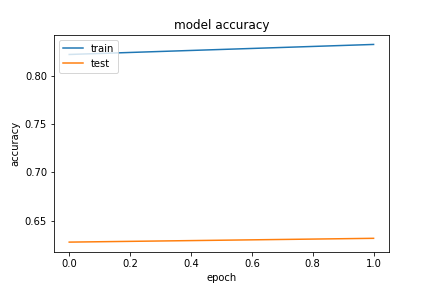

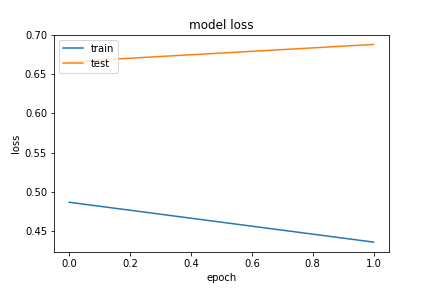

In [3]:
fixed_layers_array = [10, 13, 15]
num_epochs = 2

title_array = []
history_array = []
for num_fixed in fixed_layers_array:
    history, title = tune_layers_learningRate(num_fixed, num_epochs)
    history_array += [history]
    title_array += [title]

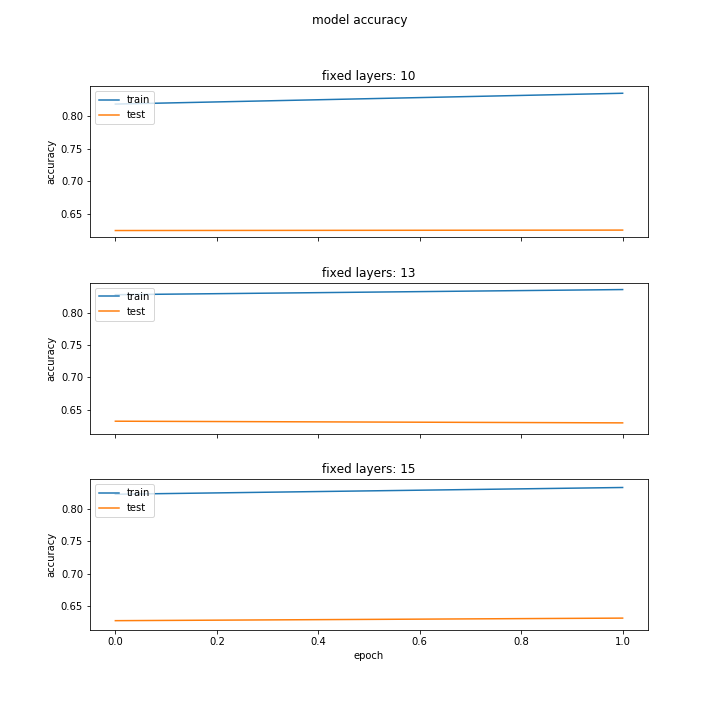

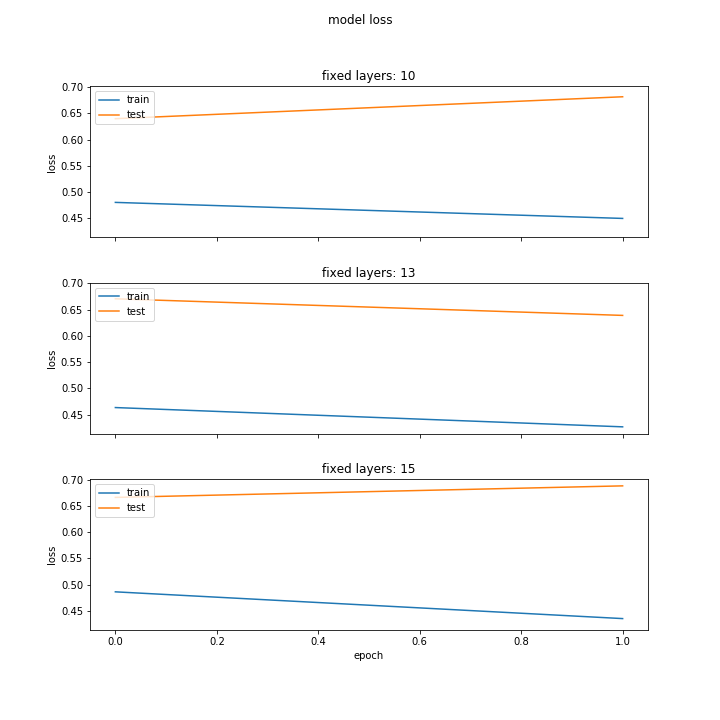

In [4]:
def plot_shared_xy(history_array, title_array, filename_prefix=""):
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = filename_prefix + "_" + time_string + "_1.png"
    fileName2 = filename_prefix + "_" + time_string + "_2.png"
    
    # plot acc
    f, axarr = plt.subplots(len(history_array), sharex=True, sharey=True, figsize=(10,10))
    for a,history in enumerate(history_array):
        axarr[a].plot(history.history['acc'])
        axarr[a].plot(history.history['val_acc'])
        axarr[a].set_title(title_array[a])
        axarr[a].set_ylabel('accuracy')
        axarr[a].legend(['train', 'test'], loc='upper left')
    plt.suptitle('model accuracy')
    axarr[-1].set_xlabel('epoch')
    f.subplots_adjust(hspace=0.3)
    plt.savefig(fileName1)
    plt.show()

    # plot loss
    f, axarr = plt.subplots(len(history_array), sharex=True, sharey=True, figsize=(10,10))
    for a,history in enumerate(history_array):
        axarr[a].plot(history.history['loss'])
        axarr[a].plot(history.history['val_loss'])
        axarr[a].set_title(title_array[a])
        axarr[a].set_ylabel('loss')
        axarr[a].legend(['train', 'test'], loc='upper left')
    plt.suptitle('model loss')
    axarr[-1].set_xlabel('epoch')
    f.subplots_adjust(hspace=0.3)
    plt.savefig(fileName2)
    plt.show()
    
    
    clear_output(True)
    display(Image(filename=fileName1))
    display(Image(filename=fileName2))
    return

plot_shared_xy(history_array, title_array, "../download/4_shared")